# Модуль 10. **Згорткові нейронні мережі**

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras

from keras.datasets import fashion_mnist

from keras import layers, models

# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau


from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [22]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
CYAN = "\033[36m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання
**Частина 2**

В цій частині ми знову будемо працювати з датасетом _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу, **що використовує VGG16 в якості згорткової основи**.


Навчіть отриману мережу на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. **Під час навчання використовуйте прийоми донавчання та виділення ознак**.



Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

     Завантаження та аналіз даних 

In [23]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [24]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [25]:
class_names = [
    "T-shirt/top",  # "Футболка/майка",
    "Trouser",  # "Штани",
    "Pullover",  # "Світшот",
    "Dress",  # "Сукня",
    "Coat",  # "Пальто",
    "Sandal",  # "Сандалі",
    "Shirt",  # "Сорочка",
    "Sneaker",  # "Кросівки",
    "Bag",  # "Сумка",
    "Ankle boot",  # "Ботильйони",
]

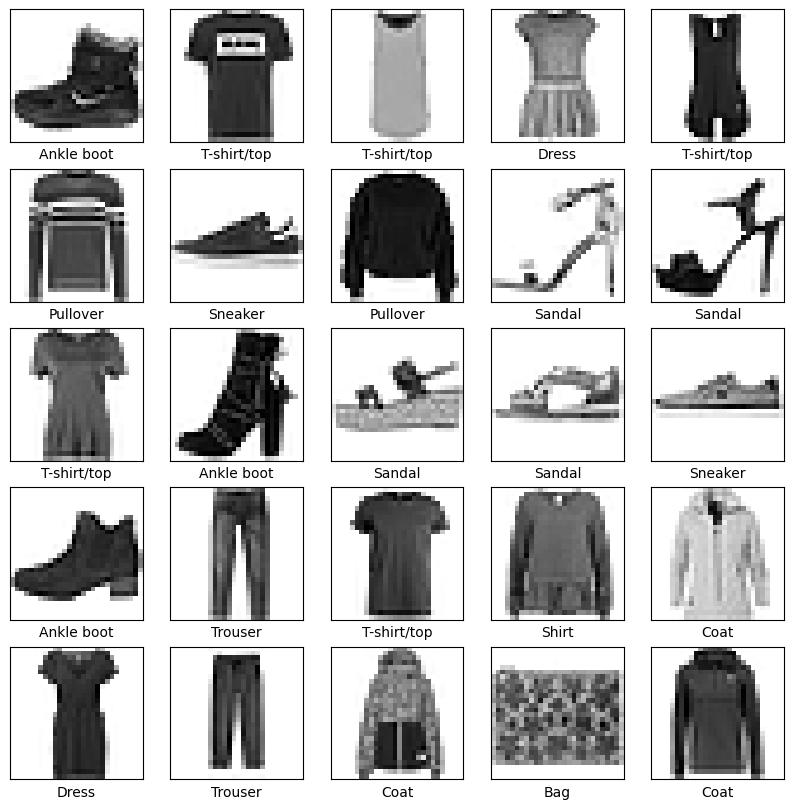

In [26]:
num_to_plot = 25

plt.figure(figsize=(10, 10))

for i in range(num_to_plot):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show() 

### Допоміжні функції

     Функція друку поточних параметрів 
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [27]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

     Функція відображення графіків історії точності та втрат 
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [28]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    plt.ylim(0, 1)
    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

     Функція підготовки моделі 
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [29]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

     Функція формування callback 
######      Аргументи: <br>1.  callbacks - Список callback'ів<br>2. patience - Кількість епох без покращення, після яких швидкість навчання буде знижена<br>3. factor_lr - Коефіцієнт, на який швидкість навчання буде знижена _(new_lr = lr * factor)_

In [30]:
def make_callback(callbacks, patience=5, factor_lr=0.4, min_lr=1e-8):

    callback = []

    if "ReduceLROnPlateau" in callbacks:
        callback.append(
            ReduceLROnPlateau(
                monitor="val_loss", factor=factor_lr, patience=patience, min_lr=min_lr
            )
        )
    if "EarlyStopping" in callbacks:
        callback.append(
            EarlyStopping(
                monitor="val_accuracy", patience=patience, restore_best_weights=True
            )
        )
    return callback

     Функція тренування моделі 
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [31]:
def train_model(
    train_images,
    train_labels,
    test_images,
    test_labels,
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    callbacks,
    patience,
    factor_lr,
    verbose=0,
    summary=0,
):

    callback = make_callback(
        callbacks,
        patience,
        factor_lr,
    )

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        callbacks=callback,
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return history, test_acc

     Функція пошуку оптимальних параметрів 

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [32]:
def find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func,
    train_images=train_images,
    train_labels=train_labels,
    test_images=test_images,
    test_labels=test_labels,
    verbose=0,
    summary=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:

        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                train_images,
                train_labels,
                test_images,
                test_labels,
                model_func,
                verbose=verbose,
                summary=summary,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

     Параметри для тренування моделей 

In [33]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 16,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 32,
    "activation": "relu",
    "metrics": ["accuracy"],
    "callbacks": ["ReduceLROnPlateau", ],
    "factor_lr": 0.2, 
    "patience": 5,
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "callbacks": [
        [""],
        ["ReduceLROnPlateau"],
        ["EarlyStopping"],
        ["ReduceLROnPlateau", "EarlyStopping"],
    ],
    "factor_lr": [0.2, 0.4, 0.6, 0.8], 
    "patience": [3, 4, 5, 6, 7, 8],
    "epochs": [5, 10, 15, 20],
    # "epochs": [10, 20, 50, 100],
    "batch_size": [8, 16, 32, 64],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],
    "loss_function": [
        "sparse_categorical_crossentropy",
    ],
    "optimizer": ["adam", "sgd", "rmsprop"],
    "hidden_units": [16, 32, 64, 128],
    "activation": ["relu", "sigmoid"],
    "metrics": [
        "accuracy",
    ],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. **Conv2D** (32, (3, 3), input_shape=(28, 28, 1))

2. **MaxPooling2D** ((2, 2))

3. **Conv2D** (64, (3, 3))

4. **MaxPooling2D** ((2, 2))

5. **Flatten**

6. **Dense** 

7. **Dense** (10)

In [34]:
def model_CNN_1(hidden_units, activation, dropout_rate):

    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(hidden_units, activation=activation),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

     Параметри, для навчання моделі 1 
###### study_sequence - Послідовність дослідження

In [35]:
study_sequence = [
    "callbacks",
    "optimizer",
    "activation",
    "hidden_units",
    # "dropout_rate",
    "batch_size",
    "epochs",
    "callbacks",
    "factor_lr",
    "patience",
    # # "loss_function",
    # # # "metrics",
    "optimizer",
    "activation",
    "hidden_units",
    # "dropout_rate",
    "batch_size",
    "epochs",
    "callbacks",
    "patience",
    "factor_lr",
]

Пошук оптимальних параметрів для моделі  **model_CNN_1**

Пошук оптимального значення параметра: callbacks 
--------------------------------------------------
Тестується значення: callbacks = ['']
--------------------------------------------------


c:\Users\ks797\AppData\Local\pypoetry\Cache\virtualenvs\ds-rEpFRPgy-py3.12\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9607 - loss: 0.1063
          тренувальні дані:   0.9602833390235901 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9066 - loss: 0.3044
          тестові дані:       0.9092000126838684 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['']
 factor_lr 	= 0.2
 patience 	= 5


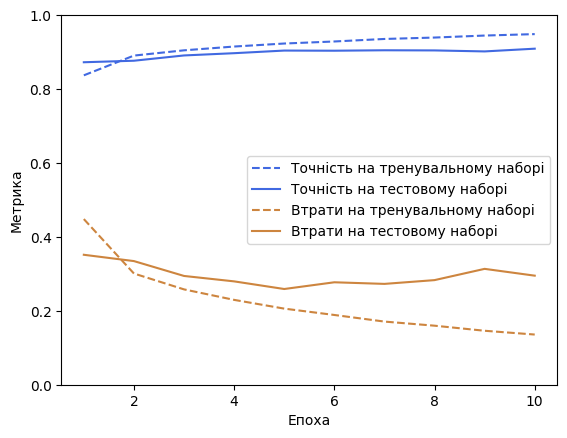

--------------------------------------------------
Тестується значення: callbacks = ['ReduceLROnPlateau']
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9480 - loss: 0.1382
          тренувальні дані:   0.9476666450500488 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9043 - loss: 0.3009
          тестові дані:       0.906000018119812 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']
 callbacks 	= ['ReduceLROnPlateau']
 factor_lr 	= 0.2
 patience 	= 5


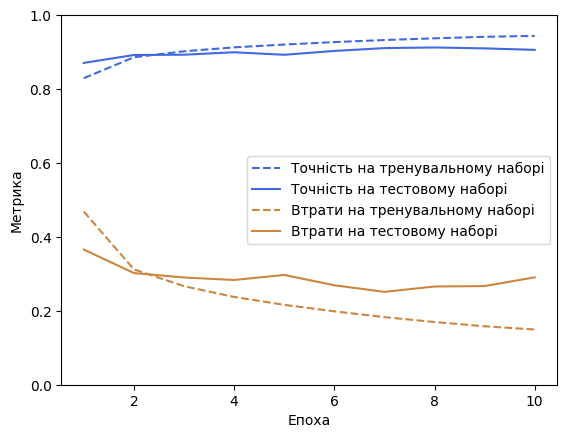

--------------------------------------------------
Тестується значення: callbacks = ['EarlyStopping']
--------------------------------------------------


In [36]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func=model_CNN_1,
    # summary=1,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_CNN_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_CN_1:</b> 
<p>Найпростіша згорткова нейромережа видає крашу точність, порівняно з мережею без згорток<br>Точність моделі склала <b>89.68%</b>)</p>
</div>

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових шари: **Conv2D** та **Dropout**_

In [ ]:
def model_CNN_2(hidden_units, activation, dropout_rate):

    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),  # added in model_2
            layers.Flatten(),
            layers.Dropout(dropout_rate),  # added in model_2
            layers.Dense(hidden_units, activation=activation),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

     Оптимальні параметри, що було визначено під час дослідження 

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_CNN_1")

In [ ]:
study_sequence = [
    "callbacks",
    "optimizer",
    "activation",
    "hidden_units",
    "dropout_rate",
    "batch_size",
    "epochs",
    "callbacks",
    "factor_lr", 
    "patience",
    # # "loss_function",
    # # # "metrics",
]

In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func=model_CNN_2,
)

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Для ускладненої моделі спостерігається <b>покращення точності</b><br>
<b>Точність на тестових даних</b> змінилася з <b>89.68%</b> для model_CNN_1 до <b>90.27%</b> для model_CNN_2</p>
</div>

***
### **Фінальне тестування** 
***
_Наостанок проведемо дослідження поведінки моделі model_CNN_2 на різних кількостях епох_

     Оптимальні параметри, що було визначено під час попереднього дослідження 

In [ ]:
print_parameters(best_parameters, "Оптимальні параметри за результатами попереднього дослідження")

In [ ]:
epochs = best_parameters["epochs"]
batch_size = best_parameters["batch_size"]
dropout_rate = best_parameters["dropout_rate"]
loss_function = best_parameters["loss_function"]
optimizer = best_parameters["optimizer"]
hidden_units = best_parameters["hidden_units"]
activation = best_parameters["activation"]
metrics = ["accuracy"]
callbacks = ["callbacs"]
factor_lr = ["factor_lr"]
patience = ["patience"]

     Параметри для фінального дослідження - досліджуємо тільки вплив кількості епох 

In [ ]:
parameters = {
    "epochs": [5, 10, 15, 20, 30, 50, 100],
}

study_sequence = [
    "epochs",
]

In [ ]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func=model_CNN_2,
    summary=1,
)

In [ ]:
print_parameters(best_parameters, "Фінальні оптимальні параметри для моделі model_CNN_2")

```
model_CNN_2 = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=activation),
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(hidden_units, activation=activation),
        layers.Dense(10, activation="softmax"),
    ]
)
```

<div class="alert alert-block alert-info">
<b>Висновки:</b> 
<p>За результатами роботи можемо стверджувати, що згорткові нейромережі дозволяють досягати суттєво більшої точності навіть на дуже простих моделях<br>Максимальна точність на тестових даних сягнула <b>90.72%</p>
</div>